In [1]:
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from keras.utils import np_utils
import matplotlib.pyplot as plt
#from keras.optimizers import SGD
from itertools import permutations
import numpy as np
import scipy.io
import pandas as pd
import random

In [2]:
#load matlab files

Xd=scipy.io.loadmat(r'G:\.shortcut-targets-by-id\1GP7DKWJranQy6jycoCLbBHoyU1gq8cLp\2_TeamWork_VisualNeglect\X_all.mat')
y=scipy.io.loadmat(r'G:\.shortcut-targets-by-id\1GP7DKWJranQy6jycoCLbBHoyU1gq8cLp\2_TeamWork_VisualNeglect\Y_p.mat')
subjID=scipy.io.loadmat(r'G:\.shortcut-targets-by-id\1GP7DKWJranQy6jycoCLbBHoyU1gq8cLp\2_TeamWork_VisualNeglect\ID_Tr.mat')

X=Xd["X_all"]
y=y["Y_p"]
ID=subjID['ID_Tr']

y=np.squeeze(y)

dimX=np.shape(X)
dimy=np.shape(y)


In [10]:
import scipy.stats

In [13]:
normalisedX = scipy.stats.zscore(X, axis=1)

In [4]:
trajectories_df=pd.DataFrame(normalisedX)
means = trajectories_df.mean(axis=1)

stds = trajectories_df.std(axis=1)
trajectories_df = (trajectories_df - means) / stds
trajectories_df['y']=y
trajectories_df['ID']=ID

In [35]:
list_ID = [elem[0] for elem in list(ID)]
list_ID = list(set(list_ID))

In [36]:
subject_sample_size = len(list_ID)
np.random.seed(14)
p = 0.8
how_many_subjects = int(0.8*subject_sample_size)
train_sample_subj = random.sample(sorted(list_ID), how_many_subjects)
test_sample_subj = [subject for subject in list_ID if subject not in train_sample_subj]

In [33]:
#train_index = np.isin(ID, train_sample_subj)
#test_index = np.isin(ID, test_sample_subj)

In [47]:
train_df = trajectories_df[trajectories_df['ID'].isin(train_sample_subj)]
test_df = trajectories_df[trajectories_df['ID'].isin(test_sample_subj)]
train_arr = np.array(train_df)[:,:-2]
test_arr = np.array(test_df)[:,:-2]

In [13]:
#train
Xtr=train_arr
ytr=train_df

#test
Xts=test_arr
yts=test_df

#get the dimensionality

dimXtr=np.shape(Xtr)
dimytr=np.shape(ytr)

dimXts=np.shape(Xts)
dimyts=np.shape(yts)

In [14]:
# process the data to fit in a keras CNN properly
# input data needs to be (N, C, X, Y) - shaped where
# N - number of samples
# C - number of channels per sample
# (X, Y) - sample size

Xtr = Xtr.reshape((dimXtr[0], 1, dimXtr[1], 1))
Xts = Xts.reshape((dimXts[0], 1, dimXts[1], 1))

#categorical lebels
ytr = np_utils.to_categorical(ytr)
yts = np_utils.to_categorical(yts)


In [ ]:
# try K-means
from sklearn.cluster import KMeans
kmeans = KMeans(
    init='random',
    n_clusters=2,
    n_init=10,
    max_iter=300,
    random_state=42
).fit_predict(normalisedX)


In [61]:
y_kmeans = kmeans.predict(normalisedX)

AttributeError: 'numpy.ndarray' object has no attribute 'predict'

In [48]:
kmeans

array([0, 1, 0, ..., 0, 0, 0])

In [45]:
kmeans.shape

(1738,)

In [34]:
labels_trans = np.copy(y)

In [35]:
labels_trans[labels_trans == -1] = 0

In [38]:
labels_trans

array([1, 1, 1, ..., 0, 0, 0], dtype=int16)

In [36]:
diff = kmeans - labels_trans

In [37]:
1 - abs(np.sum(diff)/len(labels_trans))

0.9090909090909091

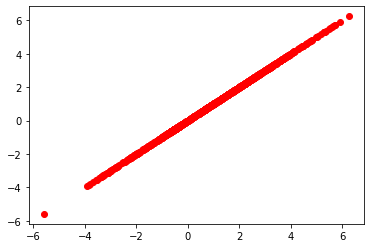

In [56]:
filtered_label0 = normalisedX[kmeans == 0]

filtered_label1 = normalisedX[kmeans == 1]

plt.scatter(filtered_label0[:,0] , filtered_label0[:,1] , color = 'red')
plt.show()

In [ ]:
centroids = kmeans.cluster_centers_

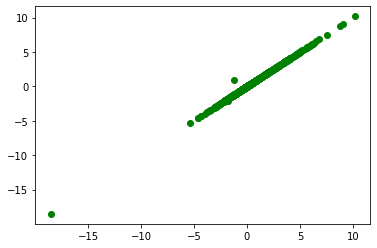

In [57]:
plt.scatter(filtered_label1[:,0] , filtered_label1[:,1] , color = 'green')
plt.show()

In [15]:
# define a CNN

cnnbene = Sequential()

#2 conv layers
cnnbene.add(Conv2D(64, (3, 1),activation="relu",input_shape=(1, dimXtr[1], 1),padding="same"))
cnnbene.add(Conv2D(64, (3, 1), activation="relu",padding="same"))

#1max pooling layer
cnnbene.add(MaxPooling2D(pool_size=(2, 1), data_format="channels_first"))

#3conv layers
cnnbene.add(Conv2D(128, (3, 1), activation="relu",padding="same"))
cnnbene.add(Conv2D(128, (3, 1), activation="relu",padding="same"))
cnnbene.add(Conv2D(128, (3, 1), activation="relu",padding="same"))

#1max pooling layer
cnnbene.add(MaxPooling2D(pool_size=(2, 1), data_format="channels_first"))

#3 conv layers
cnnbene.add(Conv2D(256, (3, 1), activation="relu",padding="same"))
cnnbene.add(Conv2D(256, (3, 1), activation="relu",padding="same"))
cnnbene.add(Conv2D(256, (3, 1), activation="relu",padding="same"))

#1 max pooling layer
cnnbene.add(MaxPooling2D(pool_size=(2, 1), data_format="channels_first"))

#2 fully connected layer with dropout regularization 
cnnbene.add(Flatten())
cnnbene.add(Dense(1024, activation="relu"))
cnnbene.add(Dropout(0.5))
cnnbene.add(Dense(2, activation="softmax"))



In [16]:
# define optimizer and objective, compile cnn
cnnbene.compile(loss="categorical_crossentropy", optimizer='adagrad', metrics=['accuracy'])

In [17]:
#sgd = SGD(lr=0.1, decay=1e-6, momentum=1, nesterov=True)
#cnnbene.compile(loss='categorical_crossentropy',
#              optimizer=sgd,
#              metrics=['accuracy'])

In [ ]:
# train
history=cnnbene.fit(Xtr, ytr, validation_data=(Xts,yts), epochs=15,verbose=2, validation_split=0.2)


In [ ]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#from keras.models import load_model

#model.save('cnnbene')


#cnnbene.save('cnnft.h5')  # creates a HDF5 file 'my_model.h5'



In [ ]:
history.history['accuracy']

